# Rasterize Vectors w. Rasterio

----------------

```{admonition} Learning Objectives
* Convert vector data into raster format with rasterio
* Understand the requirements for successful conversion
```
```{admonition} Review
* [Spatial Vector Data](c_vectors.md)
* [Spatial Raster Data](c_rasters.md)
* [Reproject Rasters w. Rasterio and Geowombat](e_raster_reproject.md)
```

----------------

Rasterizing vectors can be helpful if you want to incorporate vector data (i.e., point, line, or polygon) in your raster analysis. The process is essentially what the name suggests: We take a vector and convert it into pixels. This can be done with `rasterio`.

## Setup

We'll begin by importing our modules (click the + below to show code cell).

In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from numpy import int16

## Rasterize vectors with rasterio

We'll read in the vector file of some of California's counties. We will also read in a raster file to get the raster's metadata (i.e., coordinate system) so that we can apply those parameters to the vector file. In other words, the raster will serve as a "reference" for the the rasterization of the vector. In particular, we are going to match the shape (number of rows and columns) and the transform (UL corner location, cell size etc). For a refresher on transforms, please see the chapter on [Affine Transforms](d_affine.md).

```{important} The vector and raster **must be** be in the same coordinate system. If not, you'll need to re-project one of them so they are the same. To re-project vectors, see the chapter on [Understanding CRS Codes](d_understand_crs_codes.md). To re-project rasters, see the chapter on [Reproject Rasters w. Rasterio and Geowombat](e_raster_reproject.md).
```
One important parameter in this function is `all_touched` which determines how zones are determined by polygons relative to the reference raster's cell centroids. Setting it to `False` implies that membership in a zone, defined by a polygon geometry, should be defined by whether it contains the centroid of a cell. `True` includes any cell that geometry boundary intersects. 

```{figure} ../_static/e_raster/zonal_stats.jpg
:name: All touched rasterization 
all_touched determines the extent of zones
```

In [2]:
# Read in vector
vector = gpd.read_file(r"../_static/e_vector_shapefiles/sf_bay_counties/sf_bay_counties.shp")

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]

# Open example raster
raster = rasterio.open(r"../_static/e_raster/bay-area-wells_kde_sklearn.tif")

### Rasterize Binary Values for Shapes

With our data loaded, we can rasterize the vector using the metadata from the raster using `rasterize()` in the `rasterio.features` module. For more information on this function, check out [the `rasterio` documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize).

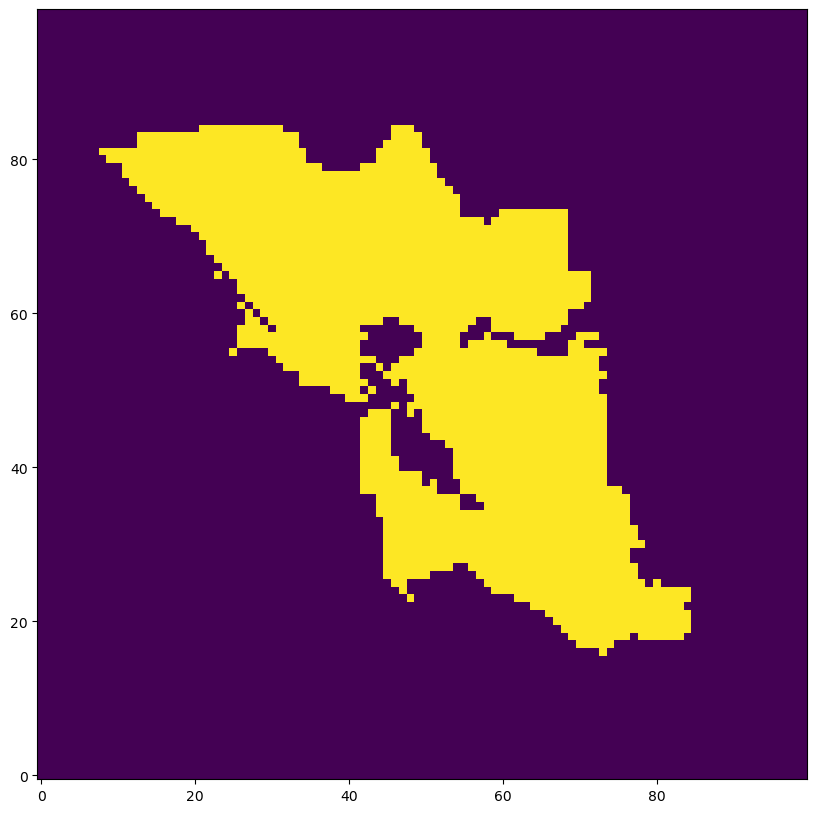

In [3]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()

### Rasterize Attribute Value using Rasterio
Often we want to burn in the value of a shapefile's attributes to the raster. We can do this by creating geometry, value pairs. In this example we take create a columns called `id` and assign the same values as the index. `id` will then be used to create our (geometry, value) pairs used for rasterization.  

Note we use `all_touched=True` to avoid gaps between counties, which can introduce its own problems b/c two counties can compete for the same cell.

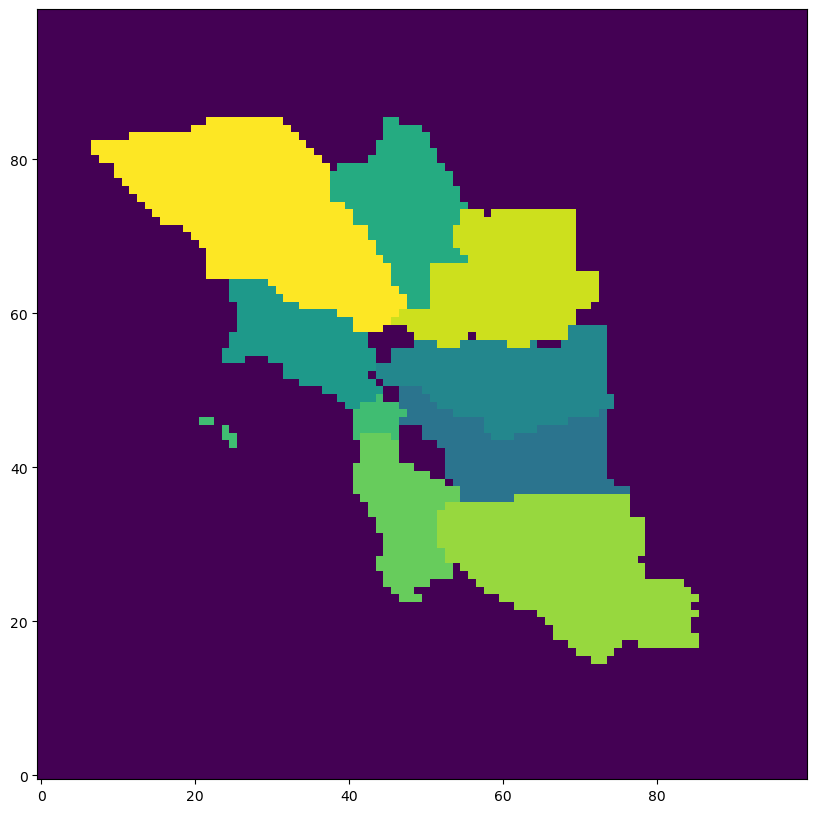

In [4]:
# create a numeric unique value for each row
vector['id'] = range(0,len(vector))

# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['id']))

# Rasterize vector using the shape and transform of the raster
rasterized = features.rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = -5,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = int16)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()

Finally, we can save the rasterized vector out.

In [5]:
with rasterio.open(
        "../temp/rasterized_vector.tif", "w",
        driver = "GTiff",
        crs = raster.crs,
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)